In [3]:
import gzip
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
from surprise import SVD
from surprise import NormalPredictor
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import GridSearchCV
import pandas as pd
#https://towardsdatascience.com/svd-where-model-tuning-goes-wrong-61c269402919

In [4]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)
    
def readCSV(path):
    f = gzip.open(path, 'rt')
    header = f.readline()
    for l in f:
        yield l.strip().split(',')

# Read task

In [30]:
# Code here
data = [line for line in readCSV("train_Interactions.csv.gz")]
Xy_train = data[:190000]
Xy_valid = data[190000:]


usersPerBook = defaultdict(set)
bookPerUser = defaultdict(set)
ratingsPerBook = defaultdict(list)
totalsumratings = 0
numratings = 0
for line in Xy_train:
    userID, bookID, rating = line
    rating = int(rating)
    if rating > 0:
        usersPerBook[bookID].add(userID)
        bookPerUser[userID].add(bookID)
        ratingsPerBook[bookID].append(rating)
        totalsumratings += rating
        numratings += 1
           
# V Number of ratings per book
num_rat_per_book = {bookID: len(users) for bookID, users in usersPerBook.items()}

# m is the minimum votes required to be listed in the chart;
items = list(num_rat_per_book.items())
items.sort(key=lambda x: x[1], reverse=True)
min_reviews = items[:round(0.5*len(items))][-1][1]

# R is the average rating of the book
avg_rat_per_book = {bookID: sum(ratings)/len(ratings) for bookID, ratings in ratingsPerBook.items()}

# C is the mean vote across the whole report
mean_vote_overall = totalsumratings / numratings

book = "b69897799"
v = num_rat_per_book[book]
m = min_reviews
R = avg_rat_per_book[book]
C = mean_vote_overall
wr = (R* (v/(v+m)) ) + (C * (m /(v + m)))
wr

# Find all movies who has a greater wr and than m

4.1963978039747225

# Rating task

In [84]:
data = [line for line in readCSV("train_Interactions.csv.gz")]
f = open("train_Interactions.csv", "w")
for line in data:
    a = ",".join(line) + "\n"
    f.write(a)
f.close()

Xy_train, Xy_valid = data[:190000], data[190000:]
Xtrain, ytrain = [x[:2] for x in Xy_train], [int(x[-1]) for x in Xy_train]
Xvalid, yvalid = [x[:2] for x in Xy_valid], [int(x[-1]) for x in Xy_valid]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ea02cf8>]],
      dtype=object)

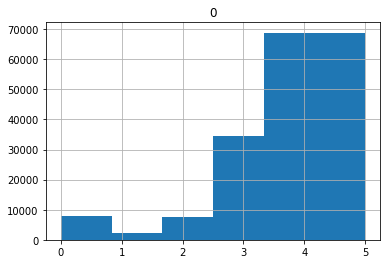

In [88]:
df = pd.DataFrame(ytrain)
df.hist(bins=6)

In [96]:
reader = Reader(rating_scale=(1, len(ytrain)))

for i, row in enumerate(Xy_train):
    Xy_train[i] = [Xy_train[i][0], Xy_train[i][1], int(Xy_train[i][2])]

df = pd.DataFrame(Xy_train)
data = Dataset.load_from_df(df, reader)

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['mae'], cv=3)
gs.fit(data)
params = gs.best_params['mae']

algo = SVD(n_epochs=params['n_epochs'],lr_all=params['lr_all'], reg_all=params['reg_all'])

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['MAE'], cv=5, verbose=True)

Evaluating MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.7919  0.7897  0.7886  0.7911  0.7932  0.7909  0.0016  
Fit time          4.84    4.63    4.57    4.69    5.16    4.78    0.21    
Test time         0.42    0.30    0.89    0.33    0.30    0.45    0.23    


{'test_mae': array([0.79188789, 0.78966767, 0.7885932 , 0.79110201, 0.79322277]),
 'fit_time': (4.844383001327515,
  4.634958744049072,
  4.571165084838867,
  4.685302972793579,
  5.163829326629639),
 'test_time': (0.4249711036682129,
  0.30343079566955566,
  0.892143964767456,
  0.326448917388916,
  0.30260133743286133)}

In [99]:
for i, row in enumerate(Xy_valid):
    Xy_valid[i] = [Xy_valid[i][0], Xy_valid[i][1], int(Xy_valid[i][2])]

predictions = algo.test(Xy_valid)
accuracy.mse(predictions, verbose=True)
for a, b in zip(predictions, yvalid):
    print(a.est,b)

MSE: 1.2130
3.864612738883191 3
4.087186408638888 3
2.804116491914767 5
3.66602513216151 2
3.5231478163154555 3
4.379687141365555 5
3.685056630379048 3
3.727520753118829 3
3.8934410614681627 5
3.8824615468759784 3
3.8723990281588736 3
4.027409523379515 5
3.4948478065915527 4
3.549219717300409 5
3.8620298530144566 4
3.4095219826454035 4
3.521077704171909 3
4.399298169979017 3
4.075875285302934 4
4.647613328837861 5
4.151353708481835 5
3.7742688487767193 3
4.163562820243992 4
3.9391660259027894 3
4.183627351764301 0
3.1197118346732524 0
3.6321627900732096 3
3.921357787168317 3
3.9884111176214736 0
4.259808222419235 3
4.216161158193536 4
4.277905022772551 5
3.488861820446381 3
3.652992545695276 5
4.132342957942904 5
3.7733665420682225 4
3.728303422673034 4
3.8996592218730055 5
3.6794187364110833 4
3.8907444256040065 5
3.807049977515899 4
3.514118999683073 4
4.828826976387566 5
4.313199914310635 5
3.9789989224049744 3
3.337309732749317 3
3.6724969750996954 3
3.777757158772705 5
4.060162002

3.9800555309847483 4
3.7799658285871223 4
3.5861854236192032 4
4.124438064608831 4
4.536676589920852 5
4.4855965634837665 5
3.4726264001648173 4
4.378032736697315 5
4.077278121396741 5
3.8426302812920654 5
3.7725339677176306 4
4.034647760888605 3
3.9325482086536714 4
3.3889591313558913 2
4.386735775113362 3
3.8861322580116315 4
3.9240603073546887 3
3.5854941241246583 4
4.342202829952982 5
4.470950467735286 5
4.010044603195264 4
3.771239513903485 5
3.5026943842158973 4
3.6120191991923702 5
4.007315729518393 4
3.9887071107389827 3
3.694169457375184 4
3.9776764951622194 3
4.068818358848566 5
3.798104168674447 3
4.248607809461188 5
4.186663170444527 3
3.7997961570263326 4
3.8840768789270057 4
3.803270479282865 5
3.9980363844266646 4
3.8573004370299904 4
4.364635534419829 5
3.6480924688388003 4
3.8283706423411967 4
4.203968846092743 5
3.6562373098885397 5
4.046201709254231 4
3.651220842324503 0
3.9590944631402563 4
3.625222507047771 5
4.16310397826263 5
3.04301197711225 0
3.368824385949056 

3.7724389907034714 3
3.951292423867212 4
3.9600216783520463 5
4.191749242937659 5
3.7788570030983815 3
3.915395689780911 4
4.221067330629989 5
3.976324278280944 4
4.367592507386565 4
4.354805804480649 5
4.277587688878811 4
3.7175176994295938 3
3.506986262097431 3
3.7787810845521843 5
3.4601362472312944 2
4.222551691685942 5
3.400709334697781 3
3.6592889477741237 0
3.7197005965828054 3
3.8777234813584207 1
3.6958610023127205 2
3.8631640186409624 5
4.042071522903597 5
3.649834420999136 4
3.5114201516983017 5
3.9431639223187984 5
3.722494196737275 5
3.9965884656295936 3
2.096497468499968 0
3.7396712267553434 2
3.624316586356642 3
3.75643678123981 4
4.018498293291643 5
4.234079813126142 3
4.021178167643285 4
3.975691683686686 5
3.525026728516367 3
4.031340333053175 5
4.4052333771367085 4
4.0883498488368035 4
2.1180488729043354 4
3.8765001537945487 5
4.533143160825878 5
4.100351345765828 4
3.6909164210279606 5
3.5695874033297823 1
3.943405476194137 4
3.353785183049459 3
4.247143783763183 5


3.6991541322227013 5
3.970732298258633 5
3.938814786063609 3
3.8152204205010873 4
3.685767047258971 3
4.283205064090003 5
3.6981352958931595 5
4.367863385765319 5
3.8536115538170908 4
4.1069505161488085 5
3.872886824177972 3
3.894221153917662 5
3.6091258450560977 4
4.040721097195579 4
3.9146257189821076 4
4.042857369114703 4
4.041815608701714 5
3.5754429657985822 4
4.230138290096938 4
3.844339083303339 4
2.6308796044906035 0
3.2606599537274166 1
3.828807355676568 5
4.0397928771606395 4
4.010857462534734 2
4.248951177742528 5
3.492393818013192 3
3.881344292666926 4
3.945668506378597 3
4.061516448464279 4
3.8096217404979376 4
3.792850045880991 5
3.941182639071277 4
4.294506040921929 4
3.7517326803195448 4
3.638994277791953 3
3.935661213318172 4
3.4366074235225543 0
4.1526907583810155 5
4.139545990645602 4
3.645820601546814 4
3.6967594035531226 4
4.067535154679966 5
3.782026462409838 4
4.193091232397916 5
4.178471424026371 5
4.2015135222741895 4
4.2677564394733025 5
4.160958673786777 4
3.

3.0379897028021925 0
3.9084376683644195 4
4.163007750006086 4
4.613633673109038 5
3.424587872703821 2
4.093021163431878 5
3.9770063714075703 4
3.125641057361532 4
4.254407759960229 5
3.4965027454090984 5
3.773832278065145 5
3.6157853856411726 3
3.4198668597389563 4
4.053357291983381 2
4.061590131648556 5
3.9434163381288148 4
4.083825995078935 5
4.005184860148515 5
3.9638455702199025 4
3.2833403885415864 2
4.046917191392448 4
4.217449721476012 4
4.134965204697256 5
4.283374817302624 4
3.1927179101618712 3
3.4323852046557555 5
4.055749897905971 4
3.7504179284268497 4
3.5663367492846474 4
3.668722408591197 4
3.996068251085084 4
3.476629416632647 4
4.063679667877657 4
4.363004339712625 5
4.065353895061992 4
3.6220158467624253 3
3.7797827191945323 3
3.97764084704758 4
3.7677656106465736 4
4.280111482512472 4
3.997514834234121 4
4.11582011003452 5
4.566711064005121 5
3.7267416968689506 4
4.204663689081989 4
4.004066932530122 3
3.6167671694580994 3
4.0569439235290465 5
4.286942127974103 3
3.9

4.234738045838945 5
3.784680525718411 4
3.95084295188132 3
3.8852493982380665 5
4.3036430256613505 5
3.736194341820177 4
3.926995977473622 4
4.019555010736277 5
4.164022883197276 5
3.9673848261957163 5
3.9701888070478426 4
3.956879109313702 5
4.204263643389362 5
4.180646160471857 5
3.606036762462273 4
4.128362660660013 3
4.115328522309354 4
3.9444946052142553 5
3.8237282789737375 2
4.034304269264047 4
3.388697536464195 3
4.603821406317549 4
4.391223736358879 5
4.230747848477336 5
3.859623541787021 5
4.335286571384479 4
3.9857760284809975 5
3.585298578914698 5
3.997648546637814 3
4.002711492191648 5
4.0580211661750285 5
4.106181547676835 4
3.715409709349281 5
4.229309586021294 5
3.0660952007143556 5
3.9236727363892387 4
4.0906141255478685 3
4.209798845103184 5
4.238410958926602 3
4.287396728621642 5
3.45017917418508 3
3.927594149276302 4
3.6436461551749573 3
3.7890614836349608 3
3.4360561862499046 3
3.0697801875486643 1
4.109917473548778 4
3.9354158733871607 5
4.21507825452824 4
4.32290

3.7787412241286704 3
3.7800592730654343 4
3.565243611312848 3
3.8168679358388484 4
3.5896469247006793 3
4.137947861373974 5
4.070309415645946 5
4.062027473846243 4
3.480864089195226 3
4.429206417981338 5
4.764194203953655 5
3.972721166470004 5
4.235472779393282 5
3.7180399810612603 4
4.035792169229537 3
4.297360768370717 5
3.8816101899390665 3
3.2921488213147057 3
3.617662752994146 5
4.177752939903414 3
3.98493449561479 5
3.8173285098568215 3
4.406029864736229 5
4.317883895593199 5
3.782833516286081 4
4.061976964946545 4
3.9089860556278646 5
3.955210296745445 5
3.8889805647522553 4
3.5621527785659026 3
4.124803025812719 5
4.069003130317586 4
4.060457495947639 3
4.335389242257112 3
3.87283401749695 3
3.623746366948961 3
3.942288978753088 4
3.8938812968491505 4
3.9419541524384263 4
3.612109207227264 4
3.74540768017426 4
3.793509888271225 3
3.8290518328397156 4
3.8340430962022016 5
3.7554712990970165 4
3.2895833602316427 4
3.543188802172618 3
3.6029138519115973 3
4.576753132742475 5
3.867

3.6729637792056007 4
3.9938075982016024 4
2.1486677080137278 0
4.180372848477369 5
4.325743238908948 5
3.7777803100207943 4
3.60053171440202 5
3.9995842669926485 4
3.4306525909605456 3
3.5662701529751595 4
4.52475231894219 5
4.140780995943795 4
4.329372883627017 5
3.989996776184001 4
4.480004384987314 5
3.654129256712256 3
2.6142815767659004 5
3.4827522372672965 4
4.192504931529874 4
3.7825395855046438 4
4.3303847237535615 4
3.523159093564485 3
3.784797936161489 3
4.159727823108819 4
3.8725106893512207 5
4.411073968613043 5
3.608595997023043 3
3.8115647189581336 5
3.6940605355615994 0
3.662972554884754 4
3.8688309691466194 4
1.9428799432716515 4
4.290941018717042 5
3.723821358322603 4
3.855589087710825 5
4.280307190998089 5
4.20392823440902 5
3.727613519137956 4
3.599942464300782 3
4.332528361654137 5
3.897982913640513 3
3.510168211970779 5
4.1060129689704645 5
4.172090387994424 4
3.614478085813802 5
4.300551268237135 5
3.7780411037323653 3
4.1754138107133025 4
4.014690156973963 5
3.99

4.197423454919035 5
3.9949799283190135 4
3.752599249181829 3
4.326401141723645 5
3.9954326945686254 0
3.8909966858946365 4
4.010049688050454 4
4.138667878360136 4
4.01697772296402 3
3.9107013057788156 4
3.8169902092443997 4
3.737181272642488 4
3.4681003029047095 5
3.937365164847391 4
3.7820846784992974 5
4.057615479087609 5
3.265277857996574 4
3.690001304343219 3
3.041381472605021 0
3.71005701044931 4
3.794706842626519 2
4.157782447251997 5
4.004201131301694 5
3.920564739803589 4
3.813151732025468 5
4.122787175843619 4
4.203036626219097 5
4.044659015474253 5
4.227708295757923 5
4.341115976548862 5
4.282082730452333 4
3.7549049692382312 3
4.018310228927406 4
3.9823276912351004 4
4.050882909350356 4
3.414361174184521 5
4.022234918557117 2
3.9443932029914253 5
3.668152215426202 4
3.519396976410837 4
4.004154099496605 5
3.840217171188873 4
3.5181271014186573 4
4.3465981982933375 5
4.203567201212766 4
3.6354629748370004 2
3.722349511478174 4
3.317616131809064 3
3.4501841122442127 3
2.755228

3.404092716723698 3
3.782355737550602 5
4.263676677815327 4
4.112292668157419 4
3.7299693611323446 5
3.7667331826144794 4
4.089927089600188 5
3.9259854418493574 4
4.195035370613351 4
4.1731422771115385 4
4.0595491710385865 3
4.162073310317668 4
4.09952728873864 4
3.923311483569356 4
3.9385673573319266 3
4.37079776366195 5
4.34386690772946 5
3.999438861297265 4
3.9731818170645536 5
3.7820504706197005 0
3.85457209948434 3
4.1513184170317565 4
3.7299204235954133 5
3.274492106625049 3
4.1246838669331085 4
3.763323867559384 2
3.8835400644344302 5
4.1093846162739665 5
4.143962243521868 5
4.280487921228085 0
3.8787418226839083 5
4.122920257491507 5
3.866796586844303 4
3.8839384142902644 4
3.8540517941645915 0
3.8261623070540285 3
4.0152441424045495 3
4.027122305830739 4
4.437657131946527 5
3.9583566912983144 4
4.161185301590524 3
3.4128090384451766 5
4.194129838762992 3
4.106696080369188 4
4.218331721430243 5
1.8899039467300947 0
3.7566139777564733 4
3.709055697490239 5
4.148759517950584 5
3.

3.9886613620507263 5
4.377359346244802 4
4.4359261662611775 4
3.9714033643760245 4
3.655849146431025 4
3.6183427945784974 3
3.54718721079004 5
4.029637308546798 5
3.871293950933777 3
3.9826656882211755 5
3.6231660630580067 4
2.438949252042678 0
3.912774117000728 4
4.1056612168431545 3
4.456885939781466 5
3.0723253362459135 5
4.448004560887505 5
3.7933697646756466 5
4.03624940335462 4
2.5605360983633036 4
4.025457166366896 4
4.316348901803479 3
3.729087213307143 5
3.0707036338370335 2
4.1024211864361115 5
4.45013393174749 5
3.9370812845198127 3
4.137131035187223 4
3.3752230927221296 0
3.9494542960036725 3
3.833785049468223 4
3.9217921456100635 5
4.266184184131753 5
3.836841819123462 3
3.7757655058619846 4
4.217507075293317 5
3.842980369278147 3
4.00501780541715 3
4.066803117483802 5
4.173860789100248 3
3.716301016652492 4
4.013499831085134 5
4.022779506741991 4
3.1635799888840475 3
3.664064359162738 4
4.180843104522165 5
3.7350858399029034 3
4.455384033828884 5
3.9859391173877374 3
3.57

4.157651803629524 5
3.4259893822627285 3
3.8648078981191025 5
3.9487377691109464 4
3.8836517038090155 4
4.336067243160461 5
3.495770974727889 3
4.116300902634339 4
3.88395760186751 5
3.8871906551487068 3
3.4753543410000605 3
3.978824112549137 5
3.5082776595645964 3
3.7025028886815643 4
4.259529209348496 5
3.051119304303594 2
4.094746087553264 4
4.240168351237013 5
3.8875663334392088 4
3.7285958170477143 5
4.070460067696416 4
3.7798568371210783 4
4.336881532268817 4
3.9229078890552067 4
3.7419396431368592 5
3.8789928273161975 4
3.832024106018572 2
3.8950412147564175 5
3.241335003598319 4
4.6194476107445945 5
3.10516974861366 2
3.768215832388082 4
3.860402714310179 4
4.456707717262702 3
4.183683183646071 5
3.843744016925659 3
4.3737231464700494 5
4.084726703604114 4
4.008088026625658 4
3.673687983228999 5
4.123654699735341 4
3.4081380493425466 4
4.142875331979229 5
3.828631313046072 4
3.0760958294829996 3
4.179754280523447 4
3.9466058552110814 3
3.4070405600323346 3
3.007445146174109 0
4

4.113354357206495 5
4.050401086478693 5
3.811576856072347 4
3.699557778640747 4
4.179452452870248 4
3.6704392671840513 3
3.8712858919044484 5
4.152412718430774 0
3.6397877198600614 5
4.09609590729664 5
3.9298277855823844 4
4.148766849743437 5
4.219329056221755 4
4.077580705740631 4
4.091143678707672 4
3.5376167322385847 4
3.9043674930905796 5
4.1431405532247 5
3.658291056874166 4
4.002084473380537 3
3.546690026237195 3
3.5995678317951523 4
3.9606212933642064 5
3.8845363907593704 5
3.9746574526563996 4
3.9536824520930822 3
3.6500354925569822 5
3.7122201240781534 0
3.9829490713487785 4
3.7691428333608306 3
3.695707238809446 4
4.831282162068981 5
4.0758963781557815 5
4.227853868334921 5
3.9473355719047887 5
3.919131102521651 3
3.9992002076558713 3
3.6745622859255715 5
3.5358106909810543 0
4.081510263781414 4
3.772304943899975 3
4.052389878310445 4
4.134432067386926 5
2.294378375189479 0
3.523236586901802 5
4.52142562120685 5
4.10614292871567 4
4.140574619751714 5
3.9518428862403066 4
3.53

In [95]:
predictions = open("predictions_Rating.txt", 'w')
for l in open("pairs_Rating.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    user, book = l.strip().split('-')
    pred = str(algo.predict(user, book).est)
    predictions.write(user + '-' + book + ',' + pred + '\n')
predictions.close()

# Deep learning

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from neuralnet_starter import trainer, test

In [160]:
def plot_error(models):
    plt.title("Errors over epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy Error")
    
    for model, label in models:
        config = model.config # If we need it
        epochs_runned = len(model.training_errors)
        x = np.arange(0,epochs_runned, 1)
        plt.plot(x, model.training_errors, label="{} Training Error".format(label))
        plt.plot(x, model.validation_errors, label="{} Validation Error".format(label))
    
    plt.legend(loc="best")
    plt.show()

def plot_accuracy(models):
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    
    for model, label in models:
        config = model.config # If we need it
        epochs_runned = len(model.training_acc)
        x = np.arange(0,epochs_runned, 1)
        plt.plot(x, model.training_acc, label="{} Training Accuracy".format(label))
        plt.plot(x, model.validation_acc, label="{} Validation Accuracy".format(label))
    
    plt.legend(loc="best")
    plt.show()
    
def hot_encode(y):
    b = np.zeros((len(y), 6))
    b[np.arange(len(y)), y] = 1
    return b

In [161]:
import numpy as np


def softmax(x):
    """
    Write the code for softmax activation function that takes in a numpy array and returns a numpy array.
    """
    exps = np.exp(x)
    return exps / np.sum(exps, axis=len(x.shape) - 1, keepdims=True)


def softmax_plus(x):
    x = x - np.max(x)
    return softmax(x)


class Activation:
    def __init__(self, activation_type="sigmoid"):
        self.activation_type = activation_type
        self.x = None  # Save the input 'x' for sigmoid or tanh or ReLU to this variable since it will be used later for computing gradients.
        self.forward_mapping = {"sigmoid": self.sigmoid, "tanh": self.tanh, "ReLU": self.ReLU}
        self.backward_mapping = {"sigmoid": self.grad_sigmoid, "tanh": self.grad_tanh, "ReLU": self.grad_ReLU}

    def forward_pass(self, a):
        return self.forward_mapping[self.activation_type](a)

    def backward_pass(self, delta):
        grad = self.backward_mapping[self.activation_type]()
        return grad * delta

    def sigmoid(self, x):
        """
        Write the code for sigmoid activation function that takes in a numpy array and returns a numpy array.
        """
        self.x = x
        print(x[:10])
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        """
        Write the code for tanh activation function that takes in a numpy array and returns a numpy array.
        """
        self.x = x
        return np.tanh(x)

    def ReLU(self, x):
        """
        Write the code for ReLU activation function that takes in a numpy array and returns a numpy array.
        """
        self.x = x
        return np.maximum(0, x)

    def grad_sigmoid(self):
        """
        Write the code for gradient through sigmoid activation function that takes in a numpy array and returns a numpy array.
        """
        sigmoid = self.sigmoid(self.x)
        return sigmoid * (1 - sigmoid)

    def grad_tanh(self):
        """
        Write the code for gradient through tanh activation function that takes in a numpy array and returns a numpy array.
        """
        return 1 - self.tanh(self.x) ** 2

    def grad_ReLU(self):
        """
        Write the code for gradient through ReLU activation function that takes in a numpy array and returns a numpy array.
        """
        x = np.array(self.x, copy=True)
        x[x <= 0] = 0
        x[x > 0] = 1
        return x


class Layer:
    def __init__(self, in_units, out_units, best_weights=False):
        np.random.seed(42)
        self.w = np.random.randn(in_units, out_units)  # Weight matrix
        if best_weights:
            self.w /= (in_units + out_units)
        self.b = np.zeros((1, out_units)).astype(np.float32)  # Bias
        self.x = None  # Save the input to forward_pass in this
        self.a = None  # Save the output of forward pass in this (without activation)
        self.d_x = None  # Save the gradient w.r.t x in this
        self.d_w = None  # Save the gradient w.r.t w in this
        self.d_b = None  # Save the gradient w.r.t b in this
        self.best_w = None
        self.best_b = None

    def forward_pass(self, x):
        """
        Write the code for forward pass through a layer. Do not apply activation function here.
        """
        self.x = x
        self.a = np.dot(x, self.w) + self.b
        return self.a

    def backward_pass(self, delta):
        """
        Write the code for backward pass. This takes in gradient from its next layer as input,
        computes gradient for its weights and the delta to pass to its previous layers.
        """
        self.d_x = np.dot(delta, self.w.T)  # gradient
        self.d_w = np.dot(self.x.T, delta)
        self.d_b = np.array([np.mean(delta, axis=0)])
        return self.d_x


class Neuralnetwork:
    def __init__(self, config, best_weights=False):
        self.layers = []
        self.x = None  # Save the input to forward_pass in this
        self.y = None  # Save the output vector of model in this
        self.targets = None  # Save the targets in forward_pass in this variable
        self.config = config

        # Error reporting
        self.training_errors = []
        self.validation_errors = []
        self.training_acc = []
        self.validation_acc = []
        for i in range(len(config['layer_specs']) - 1):
            self.layers.append(Layer(config['layer_specs'][i], config['layer_specs'][i + 1], best_weights=best_weights))
            if i < len(config['layer_specs']) - 2:
                self.layers.append(Activation(config['activation']))

        if 'learning_rate' not in config:  # set default learning rate
            config['learning_rate'] = 0.0001

    def forward_pass(self, x, targets=None):
        """
        Write the code for forward pass through all layers of the model and return loss and predictions.
        If targets == None, loss should be None. If not, then return the loss computed.
        """
        self.x = x
        for layer in self.layers:
            self.x = layer.forward_pass(self.x)

        self.y = softmax(self.x)

        loss = None
        self.targets = None
        if targets is not None:
            self.targets = targets
            loss = self.loss_func(self.y, targets)
        return loss, self.y

    def loss_func(self, logits, targets):
        '''
        find cross entropy loss between logits and targets
        '''
        if targets.ndim == 1:  # if only one dimension, convert to 2D
            targets = np.array([targets])

        l2_penalty = self.config['L2_penalty']
        number_of_images = logits.shape[0]
        number_of_categories = logits.shape[1]
        # Calculate the cross entropy loss
        cross_entropy_cost = 0
        for n in range(number_of_images):
            for c in range(number_of_categories):
                cross_entropy_cost += targets[n, c] * np.log(logits[n, c])

        cross_entropy_cost = cross_entropy_cost

        # Calculate the L2 regularization
        l2_regularization_cost = 0
        if l2_penalty > 0:
            for layer in self.layers:
                if isinstance(layer, Layer):
                    l2_regularization_cost += np.sum(np.square(layer.w))
            l2_regularization_cost *= l2_penalty
        return - (cross_entropy_cost + l2_regularization_cost) / logits.shape[0]

    def update_weights(self):
        learning_rate = self.config['learning_rate']
        momentum_gamma = self.config['momentum_gamma']
        use_momentum = self.config['momentum']
        l2_penalty = self.config["L2_penalty"]
        # Update the weights (include L2 regularization) and the bias in each layer
        for layer in self.layers:
            # Activation objects do not have weights or bias
            if isinstance(layer, Layer):
                if use_momentum:  # use momentum
                    last_momentum = 0 if layer.d_w is None else layer.d_w
                    layer.d_w = momentum_gamma * last_momentum + learning_rate * layer.d_w
                layer.d_w += (l2_penalty * layer.w)  # L2 regularization
                layer.w += learning_rate * layer.d_w
                layer.b += learning_rate * layer.d_b

    def backward_pass(self):
        '''
        implement the backward pass for the whole network.
        hint - use previously built functions.
        '''

        delta = self.targets - self.y
        for layer in reversed(self.layers):
            delta = layer.backward_pass(delta)

    def fit(self, X, Y):
        self.forward_pass(X, targets=Y)
        self.backward_pass()
        self.update_weights()


In [169]:
data = [line for line in readCSV("train_Interactions.csv.gz")]
f = open("train_Interactions.csv", "w")
for line in data:
    a = ",".join(line) + "\n"
    f.write(a)
f.close()

users = defaultdict(int)
ui = 0
books = defaultdict(int)
bi = 0
for i, row in enumerate(data):
    user, book, rating = row
    if user not in users.keys():
        users[user] = i
        ui += 1
    if book not in books.keys():
        books[book] = bi
        bi+=1
    data[i] = [users[user], books[book], int(rating)]

Xy_train, Xy_valid = data[:190000], data[190000:]
Xtrain, ytrain = np.array([x[:2] for x in Xy_train]), np.array([x[-1] for x in Xy_train])
Xvalid, yvalid = np.array([x[:2] for x in Xy_valid]), np.array([x[-1] for x in Xy_valid])
ytrain = hot_encode(ytrain)
yvalid = hot_encode(yvalid)

In [179]:
config = {}
config['layer_specs'] = [2,50,50,6]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
config['activation'] = 'tanh'  # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
config['batch_size'] = 200 # Number of training samples per batch to be passed to network
config['epochs'] = 5  # Number of epochs to train the model
config['early_stop'] = True  # Implement early stopping or not
config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
config['L2_penalty'] = 0.001  # Regularization constant
config['momentum'] = True  # Denotes if momentum is to be applied or not
config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
config['learning_rate'] = 0.001  # Learning rate of gradient descent algorithm

Epoch = 0, TrainErr: 1.3638795980694467, ValErr: 1.3620337303931571, Acc: 35.89
Epoch = 1, TrainErr: 1.3631819457620729, ValErr: 1.3606723142669137, Acc: 35.89
Epoch = 2, TrainErr: 1.3612044401442691, ValErr: 1.3574044552069144, Acc: 36.1
Epoch = 3, TrainErr: 1.3613376801153905, ValErr: 1.3583765457685801, Acc: 36.1
Epoch = 4, TrainErr: 1.3608758845328586, ValErr: 1.3570522029517156, Acc: 36.1


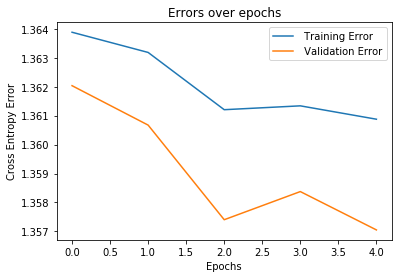

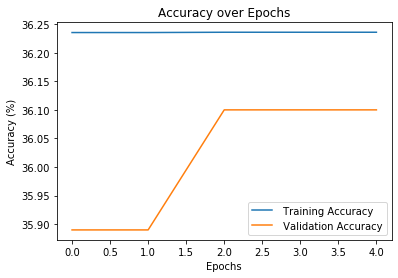

Accuracy on test data: 0.361


In [180]:
# Fit model
model = Neuralnetwork(config, best_weights=True)
#ytrain = ytrain.reshape((len(ytrain), 1))
#yvalid = yvalid.reshape((len(yvalid), 1))
trainer(model, Xtrain, ytrain, Xvalid, yvalid, config)
models = [(model, "")]

# Plot
plot_error(models)
plot_accuracy(models)

# Test
test_acc = test(model, Xvalid, yvalid, config)
print("Accuracy on test data: {}".format(test_acc))

In [181]:

loss_val, pred_val = model.forward_pass(Xvalid, targets=yvalid)
predictions = np.argmax(pred_val, axis=-1)
for value in pred_val:
    print(value)


[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252578 0.01065087 0.03562948 0.186154   0.34901889 0.37602098]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603076]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3

[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252042 0.01064859 0.03562427 0.18614992 0.34902619 0.37603062]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.34902631 0.37603077]
[0.04252034 0.01064855 0.03562418 0.18614985 0.3